U-net
=============

#### https://arxiv.org/abs/1505.04597
#### - U-Net 이라 불리는 인코더(다운샘플링)와 디코더(업샘플링)를 포함한 구조는 정교한 픽셀 단위의 segmentation이 요구되는 biomedical image segmentation task의 핵심 요소
#### - Encoder-decoder 구조 또한 semantic segmentation을 위한 CNN 구조를 자주 활용
#### - Encoder 부분에서는 encoder에서 점진적으로 spatial dimentsion을 줄여가면서 고차원의 semantic 정보를 convolution filter가 추출 해낼 수 있게 함
#### - Decoder 부분에서는 encoder에서 spatial dimension 축소로 인해 손실된 spatial 정보를 점진적으로 복원하여 보다 정교한 boundary segmentation을 완성
#### - U-Net은 기본적인 encoder-decoder 구조와 달리 Spatial 정보를 복원하는 과정에서 이전 encoder feature map 중 동일한 크기를 지닌 feature map을 가져와 prior로 활용함으로써 더 정확한 boundary segmentation을 완성

Oxford-IIIT Pets 데이터셋
- 영상, 해당 레이블과 픽셀 단위의 마스크로 구성
- 마스크는 기본적으로 각 픽셀의 레이블
- 각 픽셀은 다음 세 가지 범주 중 하나
     * class 1 : 애완동물이 속한 픽셀
     * class 2 : 애완동물과 인접한 픽셀
     * class 3 : 위에 속하지 않는 경우/주변 픽셀
- Images: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
- Annotations: https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [3]:
!curl -OL https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -OL https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   350  100   350    0     0    266      0  0:00:01  0:00:01 --:--:--   266
100   185  100   185    0     0     79      0  0:00:02  0:00:02 --:--:--   329
100  755M  100  755M    0     0  15.5M      0  0:00:48  0:00:48 --:--:-- 17.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   355  100   355    0     0    339      0  0:00:01  0:00:01 --:--:--   339
100   185  100   185    0     0     87      0  0:00:02  0:00:02 --:--:--  1057
100 18.2M  100 18.2M    0     0  4094k      0  0:00:04  0:00:04 --:--:-- 11.4M


In [4]:
!ls

annotations  annotations.tar.gz  images  images.tar.gz	sample_data


In [5]:
!ls annotations

list.txt  README  test.txt  trainval.txt  trimaps  xmls


In [26]:
import os

input_dir = 'images'
target_dir = 'annotations/trimaps'
img_size = (160,160)
num_classes = 3
batch_size = 32

input_img_paths = sorted([os.path.join(input_dir, fname)
                                  for fname in os.listdir(input_dir)
                                  if fname.endswith('.jpg') ])


target_img_paths = sorted([os.path.join(target_dir, fname)
                                  for fname in os.listdir(target_dir)
                                  if fname.endswith('.png') and not fname.startswith('.') ])

In [7]:
input_img_paths

['images/Abyssinian_1.jpg',
 'images/Abyssinian_10.jpg',
 'images/Abyssinian_100.jpg',
 'images/Abyssinian_101.jpg',
 'images/Abyssinian_102.jpg',
 'images/Abyssinian_103.jpg',
 'images/Abyssinian_104.jpg',
 'images/Abyssinian_105.jpg',
 'images/Abyssinian_106.jpg',
 'images/Abyssinian_107.jpg',
 'images/Abyssinian_108.jpg',
 'images/Abyssinian_109.jpg',
 'images/Abyssinian_11.jpg',
 'images/Abyssinian_110.jpg',
 'images/Abyssinian_111.jpg',
 'images/Abyssinian_112.jpg',
 'images/Abyssinian_113.jpg',
 'images/Abyssinian_114.jpg',
 'images/Abyssinian_115.jpg',
 'images/Abyssinian_116.jpg',
 'images/Abyssinian_117.jpg',
 'images/Abyssinian_118.jpg',
 'images/Abyssinian_119.jpg',
 'images/Abyssinian_12.jpg',
 'images/Abyssinian_120.jpg',
 'images/Abyssinian_121.jpg',
 'images/Abyssinian_122.jpg',
 'images/Abyssinian_123.jpg',
 'images/Abyssinian_124.jpg',
 'images/Abyssinian_125.jpg',
 'images/Abyssinian_126.jpg',
 'images/Abyssinian_127.jpg',
 'images/Abyssinian_128.jpg',
 'images/Abyssi

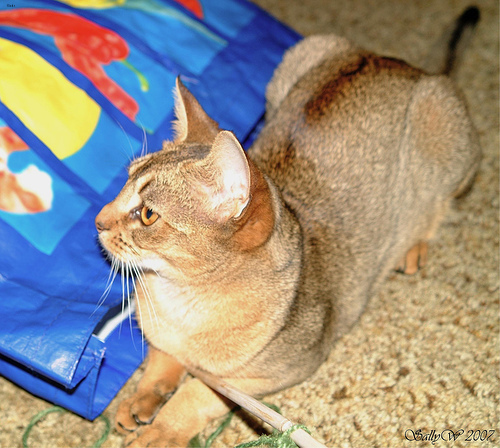

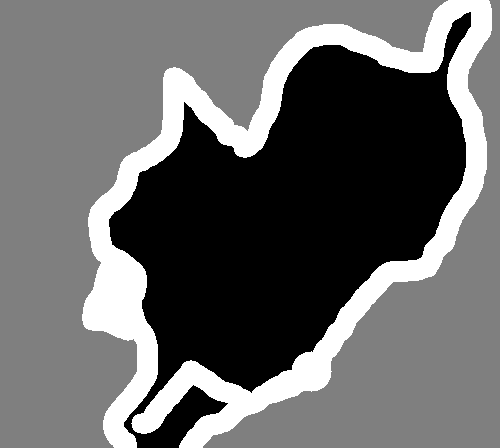

In [27]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename = input_img_paths[9]))
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [28]:
import numpy as np
from tensorflow import keras

class OxfordPets(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self,idx):
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
    x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype = 'float32')
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path, target_size = self.img_size)
      x[j] = img
    y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype = 'uint8')
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size = self.img_size, color_mode = 'grayscale')
      y[j] = np.expand_dims(img, 2)
      y[j] -= 1

    return x, y


In [30]:
import random

val_samples = 1000
random.Random(1338).shuffle(input_img_paths)
random.Random(1338).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[:-val_samples]

train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


모델구성
==============

In [31]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))

  x = layers.Conv2D(32, 3, strides = 2, padding = 'same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x

  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding = 'same')(x)

    residual = layers.Conv2D(filters, 1, strides=2, padding = 'same')(previous_block_activation)
    x = layers.add([x, residual])
    previous_block_activation = x

  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x,residual])
    previous_block_activation = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding = 'same')(x)

  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size, num_classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 80, 80, 32)           896       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 80, 80, 32)           128       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_30 (Activation)  (None, 80, 80, 32)           0         ['batch_normalization_30

모델 학습
===================

In [33]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')

callbacks = [keras.callbacks.ModelCheckpoint('oxford_segmentation.h5', save_best_only = True)]

epochs = 30
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
199/199 [==============================] - 54s 237ms/step - loss: 0.4383 - val_loss: 1.4999
Epoch 2/30
199/199 [==============================] - 56s 282ms/step - loss: 0.3904 - val_loss: 1.7322
Epoch 3/30
199/199 [==============================] - 61s 305ms/step - loss: 0.3581 - val_loss: 1.6633
Epoch 4/30
199/199 [==============================] - 49s 248ms/step - loss: 0.3299 - val_loss: 1.4678
Epoch 5/30
199/199 [==============================] - 56s 281ms/step - loss: 0.3040 - val_loss: 2.5505
Epoch 6/30
199/199 [==============================] - 45s 228ms/step - loss: 0.2830 - val_loss: 3.4847
Epoch 7/30
199/199 [==============================] - 46s 231ms/step - loss: 0.2629 - val_loss: 2.4067
Epoch 8/30
199/199 [==============================] - 48s 239ms/step - loss: 0.2481 - val_loss: 2.2163
Epoch 9/30
199/199 [==============================] - 53s 266ms/step - loss: 0.2312 - val_loss: 2.5430
Epoch 10/30
199/199 [==============================] - 54s 269ms/step - l

추론
============

In [1]:
val_preds = model.predict(val_gen)

def display_mask(i):
  mask = np.argmax(val_preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)

i = 17

display(Image(filename=val_input_img_paths[i]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)

NameError: name 'model' is not defined

DeepLab 기반 세그멘테이션
========================

  - DeepLab V1 : Semantic Image Sementation with Deep Convolutional Nets and Fully Connected CRFs, ICLR 2015.
      * Atrous convolution은 기존 convolution과 다르게 필터 내부에 빈 공간을 둔 채로 작동
      * 기존 Convolution과 동일한 양의 파라미터와 계산량을 유지하면서 filed of view (한 픽셀이 볼수 있는 영역)를 크게 가져갈 수 있음
      * Semantic segmentation에서 일반적으로 높은 성능을 내기 위해서는 convolutional neural network의 마지막에 존재하는 한 픽셀이 입력값에서 어느 크기의 영역을 커버할 수 있는질르 결정하는 receptive field 크기가 중요
      * Atrous convolution을 활용하면 파라미터 수를 늘리지 않으면서도 receptive filed를 크게 키울 수 있기 때문에 DeepLab계열 에서는 이를 적극적으로 활용


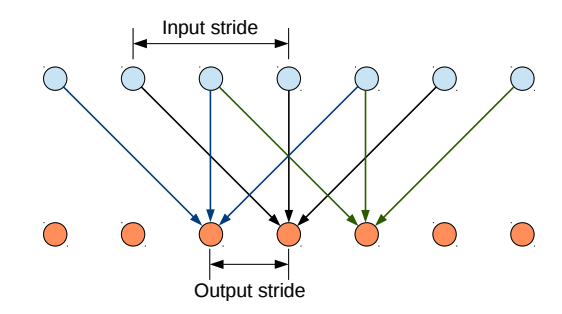

  - DeepLab V2: DeepLab: Semantic Image Segmentation with Deep Convolution Nets, Atrous Convolution and Fully Connected CRFs, TPAMI 2017.
      * Semantic segmentation의 성능을 높이기 위한 방법 중 하나로, spatial pyramid pooling 기법을 자주 사용
      * Feature map으로부터 여러 개의 rate가 다른 atrous spatial pyramid pooling (ASPP) 기법을 활용
      * multi-scale context를 모델 구조로 구현하여 보다 정확한 semantic segmentation을 수행할 수 있도록 함

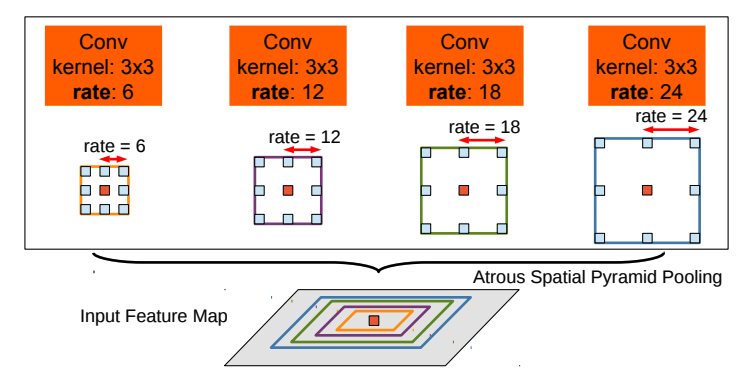

  - DeepLab V3: Rethinking Atrous Convolution for Semantic Image Segmentation, arXiv 2017.
    * Encoder: ResNet with Atrous convolution
    * Atrous Spatial Pyramid Polling(ASPP)
    * Decoder: Bilinear Upsampling

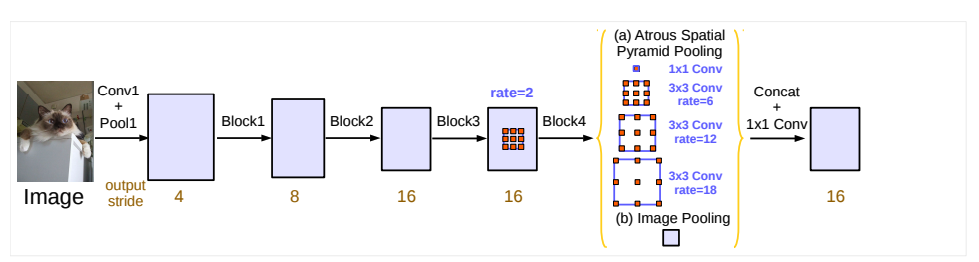

  - DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for semantic Image Segmentation, arXiv 2018.
    * Encoder:ResNet with Atrous Convolution -> Xception (inception with Separable Convolution)
    * ASPP -> ASSPP (Atrous Separable Spatial Pyramid Pooling)
    * Decoder: Bilinear Upsampling -> Simplified U-Net style decoder

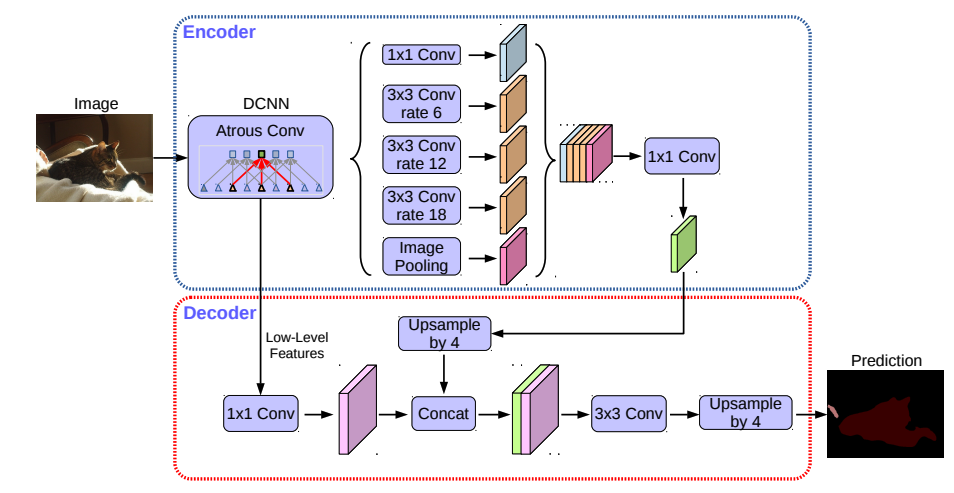

Summary
=====================
- 각 버전 별 주된 Contribution
  * v1: Atrous convolution과 후처리로 FC-CRF를 제안
  * v2: Atrous Convolution을 다양한 rate로 적용하는 ASPP 제안
  * v3: ASPP 개량 + 후처리를 사용하지 않음
  * v3+: 인코더-디코더 구조 도입 + Depthwise seperable atrous convolution 제안


데이터셋 다운로드
==============
  - Crowd Instance-level Human Parsing (CIHP)(https://arxiv.org/abs/1811.12596)
  - 38,280개의 다양한 인간 이미지
  - instance-level-human-parsing.zip(2.7G):
  (https:/drive.goolge.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz)


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
!gdown https:/drive.goolge.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
!unzip -q instance-level-human-parsing.zip

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=https:/drive.goolge.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

but Gdown can't. Please check connections and permissions.
unzip:  cannot find or open instance-level-human-parsing.zip, instance-level-human-parsing.zip.zip or instance-level-human-parsing.zip.ZIP.
